# Imports

In [1]:
import tensorflow.python.keras.backend as K

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Construção Modelo

In [5]:
from tensorflow.python.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.python.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
import cv2

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 48, 48, 1, 7

In [7]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [8]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [9]:
custom_model = Sequential()

custom_model.add(Dropout(0.5))
custom_model.add(Flatten())
custom_model.add(BatchNormalization())
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dense(7,activation='softmax'))

In [10]:
# Building Model
model = Sequential()
model.add(base_model)
model.add(custom_model)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
sequential (Sequential)      (None, 7)                 187079    
Total params: 4,236,650
Trainable params: 176,647
Non-trainable params: 4,060,003
_________________________________________________________________


In [12]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5120)              20480     
_________________________________________________________________
dense (Dense)                (None, 32)                163872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [15]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('RESNET50/model.h5')
es = EarlyStopping(verbose=1, patience=20)

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Treinamento e teste 

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                       
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [18]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   color_mode = "rgb",
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle=True)

Found 119 images belonging to 7 classes.


In [19]:
teste_y = train_dataset.classes

In [20]:
valid_dataset = train_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 28 images belonging to 7 classes.


In [21]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 98 images belonging to 7 classes.


# Fit do modelo 

In [22]:
from keras.callbacks import CSVLogger

In [23]:
epochs = 60
batch_size = 64
history = model.fit(x = train_dataset,epochs = epochs,validation_data = valid_dataset)

Epoch 1/5
2/2 [==============================] - 7s 2s/step - loss: 2.1722 - accuracy: 0.8475 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5305 - f1_score: 0.0000e+00 - val_loss: 1.9542 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4936 - val_f1_score: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 1s 289ms/step - loss: 2.1750 - accuracy: 0.8487 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5149 - f1_score: 0.0000e+00 - val_loss: 1.9527 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 1s 371ms/step - loss: 2.2207 - accuracy: 0.8475 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4789 - f1_score: 0.0000e+00 - val_loss: 1.9514 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4996 - val_f1_score: 0.0000e+00
Epoch 4/5
2/2 [==============================]

## Salvando o history em json

In [24]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'RESNET50/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## Salvando o modelo

In [30]:
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [32]:
custom_model.save("RESNET50/custom_model")

INFO:tensorflow:Assets written to: modelo_RESNET50_APAGAR/assets


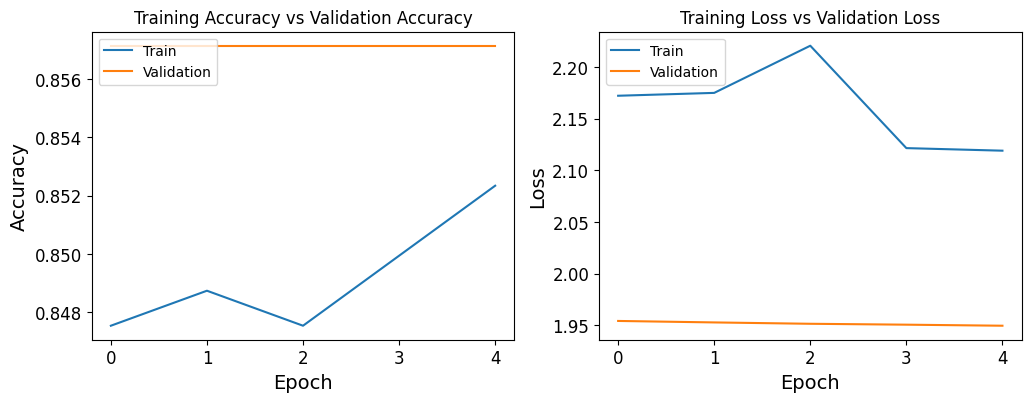

In [26]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_l = history.history['val_accuracy']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Evaluate 

In [ ]:
results = model.evaluate(test_dataset, batch_size=64)